# Deep learning classification of over 60 bird species

## Importing Libraries

In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from scipy import signal

## Importing the dataset

In [2]:
!git clone https://github.com/fabiopereira59/projet-long.git

Cloning into 'projet-long'...
remote: Enumerating objects: 11691, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 11691 (delta 17), reused 31 (delta 17), pack-reused 11660
Receiving objects: 100% (11691/11691), 83.70 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (1433/1433), done.
Updating files: 100% (11711/11711), done.


In [3]:
train_path = './projet-long/train-spec/' # path to the training set
train_labels_path = './projet-long/csv/train_spec_file_labels.csv' # path to the training set labels
val_path = './projet-long/val-spec/' # path to the validation set
val_labels_path = './projet-long/csv/val_spec_file_labels.csv' # path to the validation set labels
test_path = './projet-long/test-spec/' # path to the test set
test_labels_path = './projet-long/csv/test_spec_file_labels.csv' # path to the test set labels
labels_matching_path = './projet-long/csv/label_numbers.csv' # path to the labels matching table

## Loading the data

In [4]:
train_labels_table = pd.read_csv(train_labels_path)
val_labels_table = pd.read_csv(val_labels_path)
test_labels_table = pd.read_csv(test_labels_path)
labels_matching_table = pd.read_csv(labels_matching_path)

In [5]:
def load_images(images_path, labels_table, resize=False, size=(128, 128), grayscale=True):
    """
    Load the images from the images_path directory and return them as a numpy array.
    The labels are loaded from the labels_table dataframe.
    """
    X = []
    y = []
    for filename in os.listdir(images_path):
        if filename.endswith('.png'):
            img = Image.open(images_path + filename).convert('RGB')
            if grayscale:
                img = img.convert('L')
            if resize:
                img = img.resize(size)
            X.append(np.array(img))
            y.append(labels_table.loc[labels_table['file_names'] == filename]['label'].values[0])
    return np.array(X, dtype=np.float32), np.array(y)

In [ ]:
# Loading the training data
X_train, y_train = load_images(train_path, train_labels_table, resize=True, grayscale=False)
# Loading the validation data
X_val, y_val = load_images(val_path, val_labels_table, resize=True, grayscale=False)
# Loading the test data
X_test, y_test = load_images(test_path, test_labels_table, resize=True, grayscale=False)

In [ ]:
# Dipalying the shapes of the data
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

In [ ]:
# Display random 9 images from the training set with their labels (using the labels matching table)
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        index = np.random.randint(0, X_train.shape[0])
        axs[i, j].imshow(X_train[index].astype(np.uint8))
        axs[i, j].set_title(labels_matching_table.loc[labels_matching_table['label_num'] == y_train[index]]['label'].values[0])
        axs[i, j].axis('off')
plt.show()

## Data augmentation

In [ ]:
# Random shift, noise and pitch shift
def data_augmentation(X, y, shift=0.2, noise=0.35):
    """
    Apply random shift, noise and pitch shift to the data.
    """
    X_aug = []
    y_aug = []
    for i in range(X.shape[0]):
        # Random shift
        if np.random.random() < shift:
            shift_range = int(X.shape[1] * 0.01)
            shift = np.random.randint(-shift_range, shift_range)
            X_aug.append(np.roll(X[i], shift, axis=1))
            y_aug.append(y[i])
        # Random noise
        if np.random.random() < noise:
            X_aug.append(X[i] + np.random.normal(0, 0.2, X[i].shape))
            y_aug.append(y[i])
    return np.array(X_aug), np.array(y_aug)

In [ ]:
# Applying the data augmentation to the training data
X_train_aug, y_train_aug = data_augmentation(X_train, y_train)

In [ ]:
# Display randomly 1 image and its augmented version (precised in the title)
index = np.random.randint(0, X_train_aug.shape[0])
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X_train[index].astype(np.uint8), cmap='gray')
plt.title('Original image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(X_train_aug[index].astype(np.uint8), cmap='gray')
plt.title('Augmented image')
plt.axis('off')

In [ ]:
# Concatenating the original and augmented training data
X_train = np.concatenate((X_train, X_train_aug), axis=0)
y_train = np.concatenate((y_train, y_train_aug), axis=0)

In [ ]:
# Remove the augmented data
del X_train_aug, y_train_aug

## Data preprocessing

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

## Building the model

In [16]:
# Importing the libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# PARAMETERS
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]
if len(input_shape) == 2:
    input_shape = input_shape + (1,)
    
lr = 3e-4

# Importing the mobilenet model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# Loading the model
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights=None)

# Defining the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Displaying the model summary
model.summary()

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 512)               10486272  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 67)                17219     
                                                        

## Training the model

In [18]:
# Checkpoint Callback
from keras.callbacks import ModelCheckpoint
filepath="weights.best.hdf5"

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [17]:
# Fitting the ANN to the Training set
history = model.fit(X_train, y_train, batch_size = 16, epochs = 30, validation_data=(X_val, y_val), callbacks=callbacks_list)

Epoch 1/100
786/786 [==============================] - ETA: 0s - loss: 3.6746 - accuracy: 0.0958
Epoch 1: val_accuracy improved from -inf to 0.02146, saving model to weights.best.hdf5
786/786 [==============================] - 72s 41ms/step - loss: 3.6746 - accuracy: 0.0958 - val_loss: 4.2121 - val_accuracy: 0.0215
Epoch 2/100
786/786 [==============================] - ETA: 0s - loss: 3.2152 - accuracy: 0.1425
Epoch 2: val_accuracy improved from 0.02146 to 0.02747, saving model to weights.best.hdf5
786/786 [==============================] - 31s 39ms/step - loss: 3.2152 - accuracy: 0.1425 - val_loss: 4.2843 - val_accuracy: 0.0275
Epoch 3/100
786/786 [==============================] - ETA: 0s - loss: 3.0343 - accuracy: 0.1596
Epoch 3: val_accuracy did not improve from 0.02747
786/786 [==============================] - 29s 38ms/step - loss: 3.0343 - accuracy: 0.1596 - val_loss: 4.5208 - val_accuracy: 0.0180
Epoch 4/100
786/786 [==============================] - ETA: 0s - loss: 2.9067 - ac

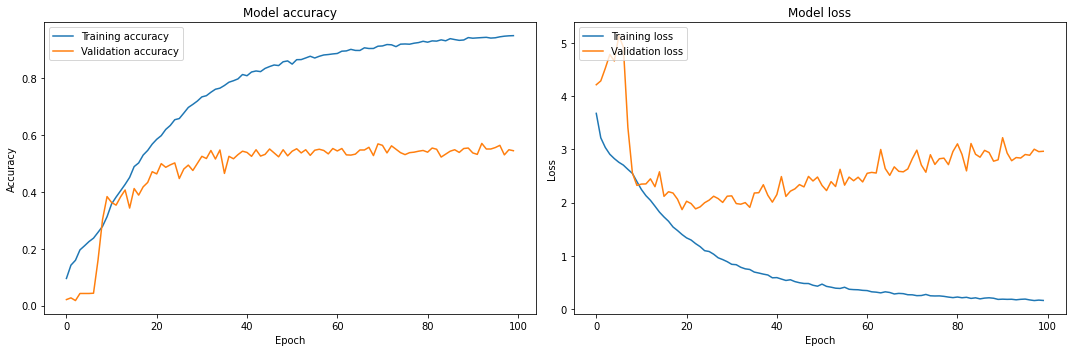

In [18]:
# Plot training & validation accuracy and loss values in the same figure (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation accuracy')
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
# Load the best model
model.load_weights(filepath)

## Evaluating the model

In [20]:
# Print the accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.5356222987174988


In [22]:
# Compute the accuacies for each class
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
class_accuracy = []
for i in range(num_classes):
    class_accuracy.append(np.sum(y_pred[y_test == i] == i) / np.sum(y_test == i))
class_accuracy = np.array(class_accuracy)

37/37 [==============================] - 1s 29ms/step


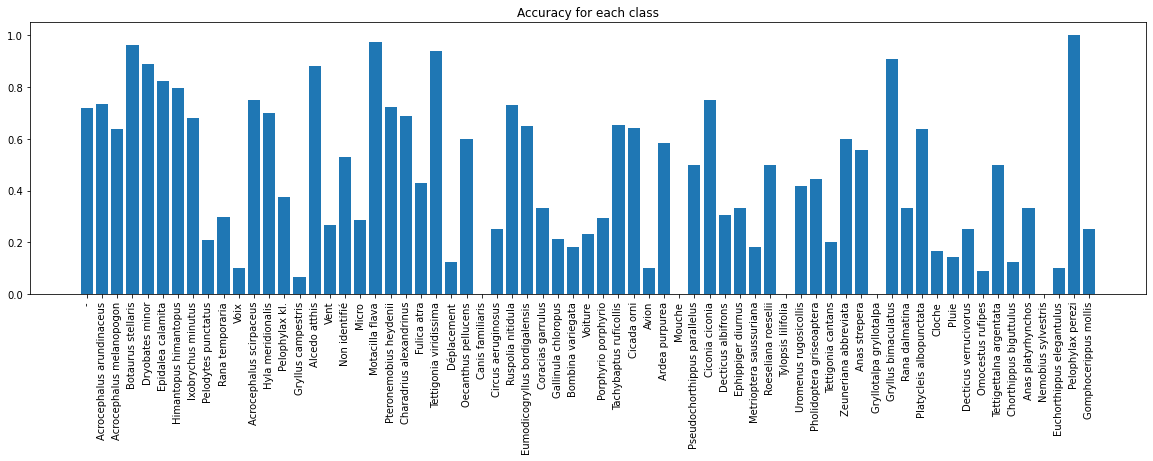

In [27]:
# Plot the accuracy for each class as a bar plot
# Plot the class names as a legend
plt.figure(figsize=(20, 5))
plt.bar(np.arange(num_classes), class_accuracy)
plt.xticks(np.arange(num_classes), labels_matching_table['label'].values, rotation=90)
plt.title('Accuracy for each class')
plt.show()
